Autores:

* Margarita Peiró
* Miguel Rodríguez
* Fernando Campoy




# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

## Preliminares:
* Definimos variables generales
* Montamos el Drive de colaboratory (si no lo estuviera)
* Instanciamos el SparkSession
* Importamos librerías

In [0]:
# Global data variables
DATA_PATH = "/content/drive/My Drive/Data Specialist Fundamentals/Data/" 

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark.sql import functions as F

In [0]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics



# Cargamos los datos 
Cargamos los datos en un DataFrame denominado **bank_df**.
Realizamos los siguientes análisis:
* Visualizamos las primeras filas para comprobar su correcta lectura
* Obtenemos dimensiones (filas y columnas)
* Visualizamos el esquema de los datos y los tipos que tienen


In [0]:
# Cargo los datos
bank_df = spark.read.csv(DATA_PATH + 'bank-full.csv', sep=';', header=True, inferSchema=True)

### Análisis del fichero: comprobación de la correcta lectura


In [0]:
bank_df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar|married|  unknow

### Análisis del fichero: comprobación de las dimensiones
nota: nos guardamos en la variable *n_rows_bank* el número de filas para estudios posteriores

In [0]:
bank_df.count(), len(bank_df.columns)
print('Número de filas: ', bank_df.count())
print('Número de columnas: ', len(bank_df.columns))

n_rows_bank = bank_df.count()


Número de filas:  45211
Número de columnas:  20


### Análisis del fichero: visualización del esquema de las variables con su tipología (type)


In [0]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



### Análisis del fichero: dtypes

In [0]:
bank_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

 ## Data Wrangling

#### Nombres de las columnas


Se observa visualmente que no requieren transformación al no tener caracteres extraños

#### Estudiamos el formato de las columnas
Generaremos dos listas de columnas con:
* cat_columns: columnas categóricas
* num_columns: columnas numéricas

In [0]:

cat_columns = [c for c,t in bank_df.dtypes if t in ['string', 'boolean']]
cat_columns
num_columns = [c for c,t in bank_df.dtypes if t in ['int', 'double']]
num_columns

print('cat_columns: ', cat_columns)
print('num_columns: ', num_columns)

cat_columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
num_columns:  ['age', 'balance', 'day', 'year', 'duration', 'campaign', 'pdays', 'previous', 'picked_up_call', 'extra_info']


#### Estudiamos los registros duplicados (registro completo)
El objetivo es comprobar que no existan registro completo 

In [0]:
bank_nodup_df = bank_df.dropDuplicates()
row_nodup=bank_nodup_df.count()
row_total=total=bank_df.count()

print('El número de registros únicos es {}, por tanto, hay {} registros duplicados'.format(row_nodup,total - row_total))



El número de registros únicos es 45211, por tanto, hay 0 registros duplicados


#### Estudiamos los valores diferentes de las columnas
El objetivo es determinar si están incorrectamente tipadas. Además listamos los diferentes valores que tienen.


In [0]:
#Valores distintos por columna
print('\nValores distintos por columna:\n')
for c,t in bank_df.dtypes:  
  print('{:.<15} : ({:6}) {: >10}'.format(c,t,bank_df.select(c).distinct().count()))  




Valores distintos por columna:

age............ : (int   )         77
job............ : (string)         12
marital........ : (string)          3
education...... : (string)          4
default........ : (string)          2
balance........ : (int   )       7168
housing........ : (string)          2
loan........... : (string)          2
contact........ : (string)          3
day............ : (int   )         31
month.......... : (string)         12
year........... : (int   )          3
duration....... : (int   )       1573
campaign....... : (int   )         48
pdays.......... : (int   )        559
previous....... : (int   )         41
poutcome....... : (string)          4
y.............. : (string)          2
picked_up_call. : (int   )          2
extra_info..... : (int   )          3


Hacemos lo mismo con categóricas mostrando las columnas con menos de 10 valores diferentes.

In [0]:
#Analisis de los valores distintos en las columnas numéricas para valorar la posibilidad de convertirlas a categóricas:
for c in num_columns:
  if bank_df.select(c).distinct().count() < 10:
    bank_df.groupBy(c).agg(F.count(c).alias('count'),(F.count(c)*100/n_rows_bank).cast('float').alias('porcen')).sort(F.col('count').desc()).show(20)


+----+-----+---------+
|year|count|   porcen|
+----+-----+---------+
|2008|27729| 61.33242|
|2009|14862| 32.87253|
|2010| 2620|5.7950497|
+----+-----+---------+

+--------------+-----+-----------+
|picked_up_call|count|     porcen|
+--------------+-----+-----------+
|             1|45208|   99.99336|
|             0|    3|0.006635553|
+--------------+-----+-----------+

+----------+-----+-----------+
|extra_info|count|     porcen|
+----------+-----+-----------+
|         1|   73| 0.16146512|
|        11|    5|0.011059255|
|      null|    0|        0.0|
+----------+-----+-----------+



Ampliamos el estudio comprobando el número de registros para cada valor y su porcentaje (tablas de frecuencias ordenadas)
Con esto verificaremos si existen **valores muy predominantes**.
En el caso de encontrarlos decidiremos que hacer con las columnas

In [0]:
# n_row_bank es una variable que contiene el número de filas y está informada en el apartado de dimensiones
for c in cat_columns:
  bank_df.groupBy(c).agg(F.count(c).alias('count'),(F.count(c)*100/n_rows_bank).cast('float').alias('porcen')).sort(F.col('count').desc()).show(20)


+-------------+-----+----------+
|          job|count|    porcen|
+-------------+-----+----------+
|  blue-collar| 9732| 21.525734|
|   management| 9458| 20.919687|
|   technician| 7597| 16.803432|
|       admin.| 5171| 11.437482|
|     services| 4154|  9.188029|
|      retired| 2264|  5.007631|
|self-employed| 1579|  3.492513|
| entrepreneur| 1487| 3.2890227|
|   unemployed| 1303|  2.882042|
|    housemaid| 1240| 2.7426953|
|      student|  938| 2.0747163|
|      unknown|  288|0.63701314|
+-------------+-----+----------+

+--------+-----+---------+
| marital|count|   porcen|
+--------+-----+---------+
| married|27214|60.193317|
|  single|12790|28.289576|
|divorced| 5207|11.517109|
+--------+-----+---------+

+---------+-----+---------+
|education|count|   porcen|
+---------+-----+---------+
|secondary|23202| 51.31937|
| tertiary|13301|29.419832|
|  primary| 6851|15.153392|
|  unknown| 1857|4.1074076|
+---------+-----+---------+

+-------+-----+---------+
|default|count|   porcen|
+---

#### Estudiamos los principales estadísticos de las variables numéricas
Para ello mostraremos:
* Media
* Desviación Típica
* Mínimo
* Máximo

In [0]:
#Para calcular multiples métricas en multiples columnas, juntamos listas de operaciones.

avgs = [F.avg(col).alias('avg_' + col) for col in num_columns]
maxs = [F.max(col).alias('max_' + col) for col in num_columns]
mins = [F.min(col).alias('min_' + col) for col in num_columns]
stds = [F.stddev(col).alias('std_' + col) for col in num_columns]
operations = avgs + stds + maxs + mins 

results = bank_df.select(operations).first()

for col in num_columns:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{:<15}: avg={:<10} std={:<10} min={:<10} max={:<10}'.format(col, round(avg, 2), round(std, 2), mini, maxi))



age            : avg=40.94      std=10.62      min=18         max=95        
balance        : avg=1362.27    std=3044.77    min=-8019      max=102127    
day            : avg=15.81      std=8.32       min=1          max=31        
year           : avg=2008.44    std=0.6        min=2008       max=2010      
duration       : avg=258.16     std=257.53     min=0          max=4918      
campaign       : avg=2.76       std=3.1        min=1          max=63        
pdays          : avg=40.2       std=100.13     min=-1         max=871       
previous       : avg=0.58       std=2.3        min=0          max=275       
picked_up_call : avg=1.0        std=0.01       min=0          max=1         
extra_info     : avg=1.64       std=2.47       min=1          max=11        


Para completar pintamos las numéricas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b8caafa20>,
      dtype=object)

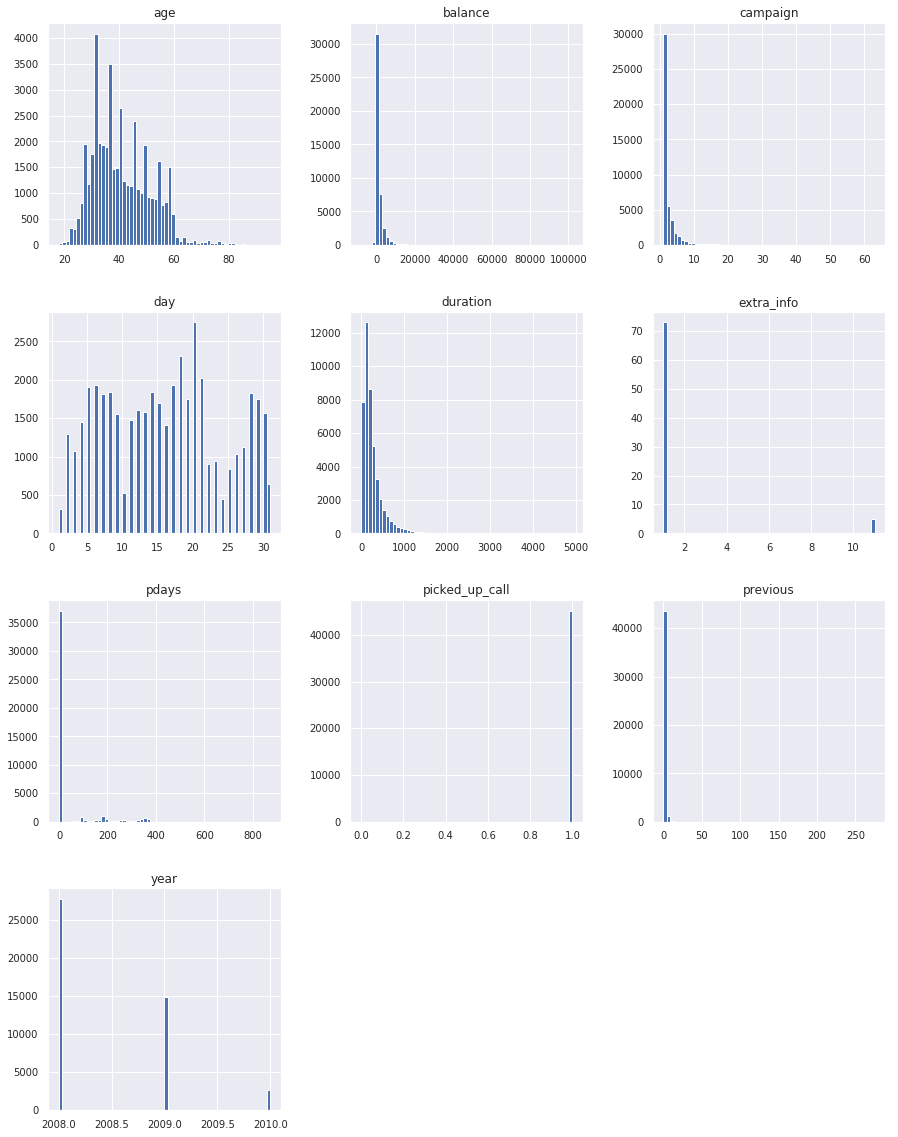

In [0]:
#creamos un dataframe de pandas de las variables numéricas
bank_pd_num = bank_df.select(num_columns).toPandas()

#pintamos histogramas de las variables numéricas
bank_pd_num.hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10)


#### Estudiamos los nulos en el dataset

In [0]:
#Estudio de registros nulos:
n_rows_bank = bank_df.count()

missing_ops = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / n_rows_bank, 2).alias(c) 
               for c in bank_df.columns]

bank_df.select(missing_ops).show()



+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|0.0|0.0|    0.0|      0.0|    0.0|    0.0|    0.0| 0.0|    0.0|0.0|  0.0| 0.0|     0.0|     0.0|  0.0|     0.0|     0.0|0.0|           0.0|     99.83|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+



#### Estudiamos a continuación los outliers de las variables numéricas 

Pintamos boxplot

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


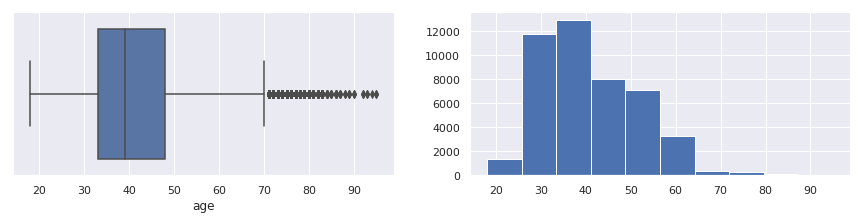

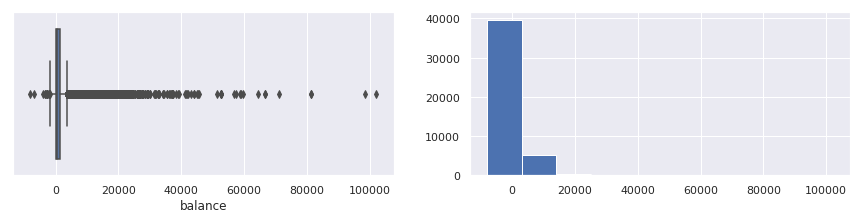

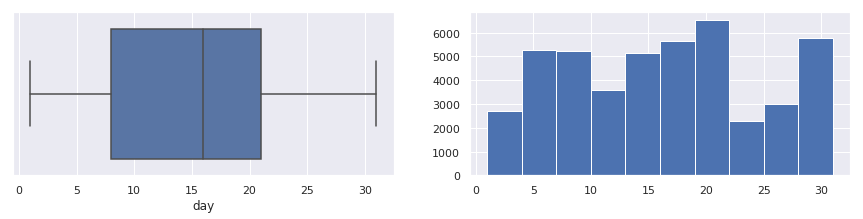

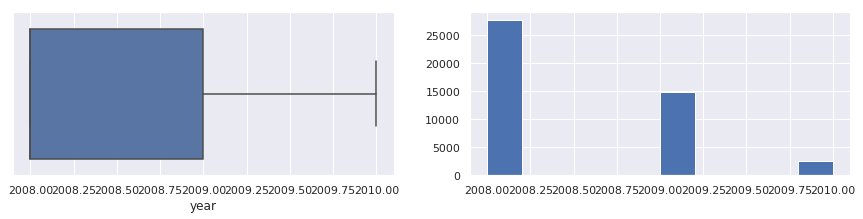

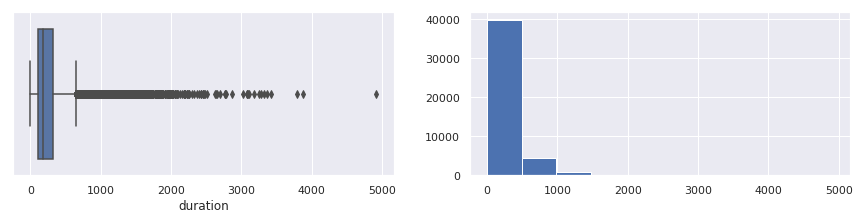

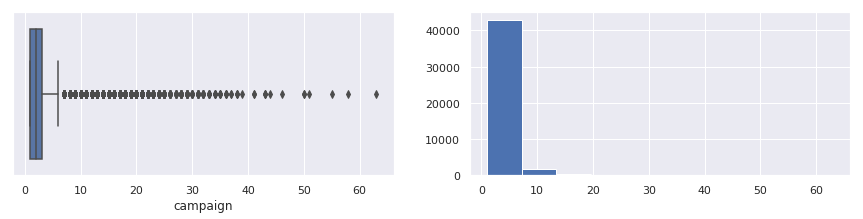

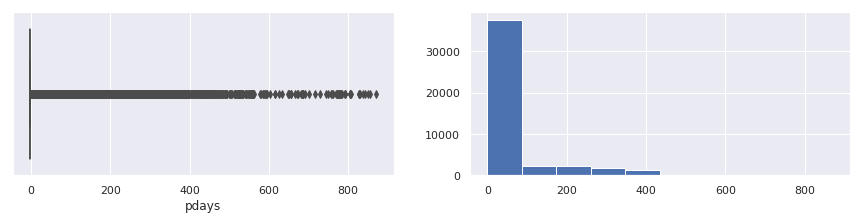

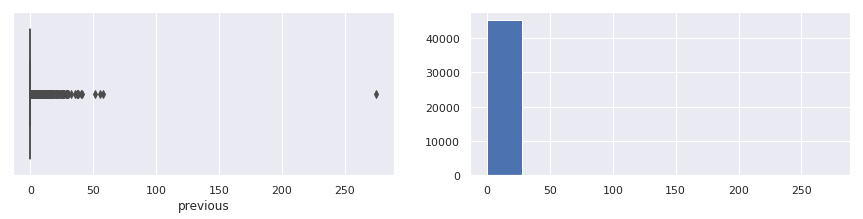

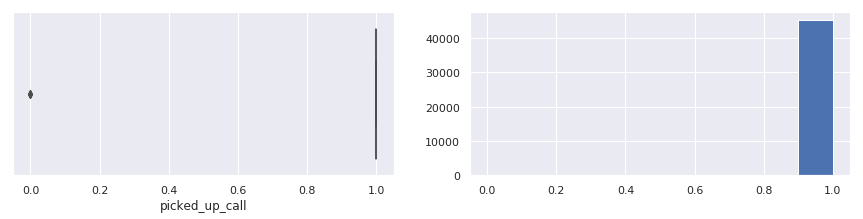

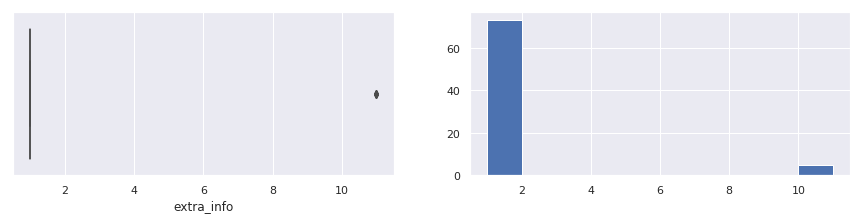

In [0]:
#boxplot de variables numéricas para estudio de outliers
bank_pd_num=bank_df.select(num_columns).toPandas()

for cols in bank_pd_num.columns:
    plt.figure(figsize = (15, 3))
    plt.subplot(1, 2, 1)
    ax = sns.boxplot(x=bank_pd_num[cols])
   
    plt.subplot(1, 2, 2)
    plt.hist(bank_pd_num[cols])


Listamos outliers

In [0]:
#Estudio de outliers en variables numéricas

for col in num_columns:
   
  q1, q3 = bank_df.approxQuantile(col, [0.25, 0.75], 0.01)
  iqr = q3 - q1
    
  min_thresh = q1 - 1.5 * iqr
  max_thresh = q3 + 1.5 * iqr
    
  df_outliers = bank_df.filter((F.col(col) < min_thresh) | (F.col(col) > max_thresh)).select(col)
    
  num_outliers = bank_df.filter((F.col(col) < min_thresh) | (F.col(col) > max_thresh)).select(col).count()
    
  
  if num_outliers > 0:
    print ("-------------------------------------------------------------------------------")
    print ("Variable '{}'' con q1: {} , q3: {} e iqr: {}".format(col,q1,q3,iqr))
    print("Número de outliers: {} con valores:".format(num_outliers))
    df_outliers.groupBy(F.col(col)).count().orderBy(F.col('count').desc()).show(5)




-------------------------------------------------------------------------------
Variable 'age'' con q1: 32.0 , q3: 48.0 e iqr: 16.0
Número de outliers: 381 con valores:
+---+-----+
|age|count|
+---+-----+
| 73|   44|
| 77|   44|
| 75|   39|
| 74|   37|
| 76|   32|
+---+-----+
only showing top 5 rows

-------------------------------------------------------------------------------
Variable 'balance'' con q1: 61.0 , q3: 1390.0 e iqr: 1329.0
Número de outliers: 4872 con valores:
+-------+-----+
|balance|count|
+-------+-----+
|   8304|   11|
|   6138|   10|
|   4401|    7|
|   3696|    7|
|   4321|    6|
+-------+-----+
only showing top 5 rows

-------------------------------------------------------------------------------
Variable 'duration'' con q1: 100.0 , q3: 314.0 e iqr: 214.0
Número de outliers: 3334 con valores:
+--------+-----+
|duration|count|
+--------+-----+
|     676|   17|
|     638|   17|
|     641|   15|
|     744|   15|
|     645|   15|
+--------+-----+
only showing top 5 r


## Conclusiones análisis preliminar:

Analizando todos estos puntos vemos:

* Existen tres columnas que realmente son el día, mes y año de la fecha de contacto. Vamos a crear una nueva columna **contact_date** que permitirá operar más fácilmente con ella.

* En la definición en UCI de la columna **pdays** se comenta que el valor 999 significa que el cliente no ha sido previamente contactado. Al ser esta columna *integer* significa que este valor distorsionaría la media o cualquier operación que se quiera realizar. Proponemos establecer el valor 999 a nulo para evitar esta distorsión.

 Sin embargo revisando el resto de estadísticos generados, vemos que no hay ninguno al ser el máximo de dicha columna 871, pero hemos observado que el valor mínimo es -1. Tras consultarlo entendemos que el valor -1 es el equivalente al 999 de la definición UCI.
 
 Por tanto se debe poner a cero para que no distorsione el cálculo de estadísticos.

* Sobre la variable dependiente **y** consideramos que no tiene un nombre adecuado ni una tipología correcta. En la definición UCI indica que es binaria y por tanto vamos a cambiarla a tipo booleana, que facilitará los futuros modelos predictivos de clasificación. Asimismo vamos a cambiar el nombre a algo más descriptivo: **subscribed_dep_boo**

 Como la matriz de correlación sólo trabaja con numéricas y tenemos dudas sobre si incluirá la columna **subscribed_dep_boo** que es boolean hemos creado una columna nueva que se llama **subscribed_dep_num** que es numérica.


* Vamos a mantener el resto de variables con dos valores porque están definidas en UCI como categoricas. Esto tiene sentido por su naturaleza ya que podrían tener 3 valores (así está definido). Por tanto mantenemos como categorícas las siguientes:

 - **loan**
 - **housing**
 - **default**


* La variable **contact** está definida en UCI como categórica y tiene dos valores. Sin embargo observamos que existen tres valores. Se podría transformar el valor "UnKnown" a nulo, pero al ser categórica no aporta mucho. 

* Consideramos eliminar las columnas:

 - **picked_up_call** por tener un valor que se repite el 99,99% de los registros
 - **extra_info** por tener nulos el 99,83% de los registros



## Modificaciones DataFrame

### Creamos columna *contact_date*

In [0]:
#Añadimos columna de tipo date con la fecha de contacto 
bank_df_final = bank_df.withColumn('contact_date',
                           F.to_date(F.concat(F.col('year').cast('string'),F.col('month'),F.col('day').cast('string')),'yyyyMMMdd'))
bank_df_final.select('day','month','year','contact_date').show(3)



+---+-----+----+------------+
|day|month|year|contact_date|
+---+-----+----+------------+
|  5|  may|2008|  2008-05-05|
|  5|  may|2008|  2008-05-05|
|  5|  may|2008|  2008-05-05|
+---+-----+----+------------+
only showing top 3 rows



### Convertir a cero el valor -1 de la variable *pday*

In [0]:
#Analizamos la columna pdays y vemos que el valor -1 corresponderia con un null

bank_df_final.groupBy('pdays').agg(F.count('pdays').alias('count')).sort(F.col('count').desc()).show(5)

#Converimos -1 a null
bank_df_final=bank_df_final.withColumn('pdays', F.when(F.col('pdays') ==-1, 0).otherwise(F.col('pdays')))

bank_df_final.groupBy('pdays').agg(F.count('pdays').alias('count')).sort(F.col('count').desc()).show(5)

print('Numero de nulos: ',bank_df_final.filter(F.col('pdays').isNull()).count())



+-----+-----+
|pdays|count|
+-----+-----+
|   -1|36954|
|  182|  167|
|   92|  147|
|  183|  126|
|   91|  126|
+-----+-----+
only showing top 5 rows

+-----+-----+
|pdays|count|
+-----+-----+
|    0|36954|
|  182|  167|
|   92|  147|
|   91|  126|
|  183|  126|
+-----+-----+
only showing top 5 rows

Numero de nulos:  0


### Cambiamos el nombre de la variable *y* a *subscribed_dep_boo* y casteamos a boolean:

In [0]:
#Conversión de la columna 'y' a booleana y renombramos

bank_df_final=bank_df_final.withColumn('subscribed_dep_boo', F.when(F.col('y') =='yes', True).otherwise(False))

bank_df_final.select('y','subscribed_dep_boo').show(5)

bank_df_final.select('y','subscribed_dep_boo').dtypes


+---+------------------+
|  y|subscribed_dep_boo|
+---+------------------+
| no|             false|
| no|             false|
| no|             false|
| no|             false|
| no|             false|
+---+------------------+
only showing top 5 rows



[('y', 'string'), ('subscribed_dep_boo', 'boolean')]

### Creamos la columna *subscribe_dep_num* (integer) para la matriz de correlaciones

In [0]:
 #Creamos nueva columna numerica a partir de 'y' 

bank_df_final=bank_df_final.withColumn('subscribed_dep_num', F.when(F.col('y') =='yes', 1).otherwise(0))

bank_df_final.select('y','subscribed_dep_num').show(5)

bank_df_final.select('y','subscribed_dep_num').dtypes



+---+------------------+
|  y|subscribed_dep_num|
+---+------------------+
| no|                 0|
| no|                 0|
| no|                 0|
| no|                 0|
| no|                 0|
+---+------------------+
only showing top 5 rows



[('y', 'string'), ('subscribed_dep_num', 'int')]

### Eliminamos las columnas *picked_up_call* y *extra_info*

In [0]:
#Eliminamos las columnas picked_up_call, extra_info

bank_df_final = bank_df_final.drop('picked_up_call','extra_info')

bank_df_final.columns 



['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y',
 'contact_date',
 'subscribed_dep_boo',
 'subscribed_dep_num']

###  Recalculamos lista de variables categóricas y numéricas

In [0]:
cat_columns = [c for c,t in bank_df_final.dtypes if t in ['string', 'boolean']]
cat_columns
num_columns = [c for c,t in bank_df_final.dtypes if t in ['int', 'double']]
num_columns

print('cat_columns: ', cat_columns)
print('num_columns: ', num_columns)

cat_columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y', 'subscribed_dep_boo']
num_columns:  ['age', 'balance', 'day', 'year', 'duration', 'campaign', 'pdays', 'previous', 'subscribed_dep_num']


### Visualizamos el dataframe para comprobar los cambios

In [0]:
bank_df_final.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+------------+------------------+------------------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|contact_date|subscribed_dep_boo|subscribed_dep_num|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+------------+------------------+------------------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|    0|       0| unknown| no|  2008-05-05|             false|                 0|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|    0|       0| unknown| no|  2008-05-05|             false|                 0|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unkno

## Análisis Exploratorio de Datos

#### Matriz de correlación

In [0]:
## Matriz de correlación

corr_matrix = Statistics.corr(bank_df_final.select(num_columns).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')

corr_matrix = pd.DataFrame(corr_matrix, columns=num_columns, index=num_columns)
corr_matrix



,age,balance,day,year,duration,campaign,pdays,previous,subscribed_dep_num
age,1.000000,0.097783,-0.009120,-0.008022,-0.004648,0.004760,-0.023841,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.031499,0.021560,-0.014578,0.003330,0.016674,0.052838
day,-0.009120,0.004503,1.000000,-0.170216,-0.030206,0.162490,-0.093024,-0.051710,-0.028348
year,-0.008022,0.031499,-0.170216,1.000000,0.037030,-0.166185,0.462312,0.293186,0.329994
duration,-0.004648,0.021560,-0.030206,0.037030,1.000000,-0.084570,-0.001584,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,-0.166185,-0.084570,1.000000,-0.088508,-0.032855,-0.073172
pdays,-0.023841,0.003330,-0.093024,0.462312,-0.001584,-0.088508,1.000000,0.454288,0.103323
previous,0.001288,0.016674,-0.051710,0.293186,0.001203,-0.032855,0.454288,1.000000,0.093236
subscribed_dep_num,0.025155,0.052838,-0.028348,0.329994,0.394521,-0.073172,0.103323,0.093236,1.000000


Gráficamente:

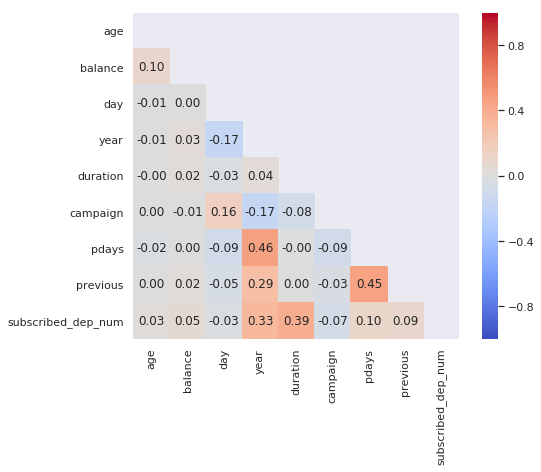

In [0]:
#Eliminamos el triángulo superior de la matriz de correlación y la representamos.

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

corr_matrix = corr_matrix.mask(mask)
corr_matrix

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')


## Primera conclusión
Observamos que hay muy poca correlación de la columna **subscribed_dep_num** con el resto de variables numéricas.
Para ampliar el estudio de correlación convertimos las columnas categóricas siguientes a numéricas y volvemos a sacar la matriz de correlación:
* marital
* education
* housing
* default
* loan
* contact



### Casteamos la columna *marital* a numérico (codificamos) *marital_num*


In [0]:
#Conversión de la columna 'marital' a numerica

bank_df_final=bank_df_final.withColumn('marital_num', F.when(F.col('marital') =='married',1)\
                                                .when(F.col('marital') =='single',2)\
                                                .when(F.col('marital') =='divorced',3).otherwise(0))
bank_df_final.select('marital','marital_num').show(5)

bank_df_final.select('marital','marital_num').dtypes



+-------+-----------+
|marital|marital_num|
+-------+-----------+
|married|          1|
| single|          2|
|married|          1|
|married|          1|
| single|          2|
+-------+-----------+
only showing top 5 rows



[('marital', 'string'), ('marital_num', 'int')]

### Casteamos la columna *education* a numérico (codificamos) *education_num*

In [0]:
#Conversión de la columna 'education' a numerica

bank_df_final=bank_df_final.withColumn('education_num', F.when(F.col('education') =='primary',1)\
                                                .when(F.col('education') =='secondary',2)\
                                                .when(F.col('education') =='tertiary',3)\
                                                .when(F.col('education') =='unknow',4).otherwise(0))

bank_df_final.select('education','education_num').show(5)

bank_df_final.select('education','education_num').dtypes


+---------+-------------+
|education|education_num|
+---------+-------------+
| tertiary|            3|
|secondary|            2|
|secondary|            2|
|  unknown|            0|
|  unknown|            0|
+---------+-------------+
only showing top 5 rows



[('education', 'string'), ('education_num', 'int')]

### Casteamos la columna *default* a numérico (codificamos) *default_num*

In [0]:
#Conversión de la columna 'default' a numerica

bank_df_final=bank_df_final.withColumn('default_num', F.when(F.col('default') =='no',1)\
                                                .when(F.col('default') =='yes',2).otherwise(0))

bank_df_final.select('default','default_num').show(5)

bank_df_final.select('default','default_num').dtypes


+-------+-----------+
|default|default_num|
+-------+-----------+
|     no|          1|
|     no|          1|
|     no|          1|
|     no|          1|
|     no|          1|
+-------+-----------+
only showing top 5 rows



[('default', 'string'), ('default_num', 'int')]

### Casteamos la columna *housing* a numérico (codificamos) *housing_num*

In [0]:
#Conversión de la columna 'housing' a numerica

bank_df_final=bank_df_final.withColumn('housing_num', F.when(F.col('housing') =='no',1)\
                                                .when(F.col('housing') =='yes',2).otherwise(0))

bank_df_final.select('housing','housing_num').show(5)

bank_df_final.select('housing','housing_num').dtypes


+-------+-----------+
|housing|housing_num|
+-------+-----------+
|    yes|          2|
|    yes|          2|
|    yes|          2|
|    yes|          2|
|     no|          1|
+-------+-----------+
only showing top 5 rows



[('housing', 'string'), ('housing_num', 'int')]

### Casteamos la columna *loan* a numérico (codificamos) *loan_num*

In [0]:
#Conversión de la columna 'loan' a numerica

bank_df_final=bank_df_final.withColumn('loan_num', F.when(F.col('loan') =='no',1)\
                                                .when(F.col('loan') =='yes',2).otherwise(0))

bank_df_final.select('loan','loan_num').show(5)

bank_df_final.select('loan','loan_num').dtypes


+----+--------+
|loan|loan_num|
+----+--------+
|  no|       1|
|  no|       1|
| yes|       2|
|  no|       1|
|  no|       1|
+----+--------+
only showing top 5 rows



[('loan', 'string'), ('loan_num', 'int')]

### Casteamos la columna *contact* a numérico (codificamos) *contact_num*

In [0]:
#Conversión de la columna 'contact' a numerica

bank_df_final=bank_df_final.withColumn('contact_num', F.when(F.col('contact') =='cellular',1)\
                                                .when(F.col('contact') =='telephone',2)\
                                                .when(F.col('contact') =='unknown',3).otherwise(0))

bank_df_final.select('contact','contact_num').show(5)

bank_df_final.select('contact','contact_num').dtypes


+-------+-----------+
|contact|contact_num|
+-------+-----------+
|unknown|          3|
|unknown|          3|
|unknown|          3|
|unknown|          3|
|unknown|          3|
+-------+-----------+
only showing top 5 rows



[('contact', 'string'), ('contact_num', 'int')]

### Casteamos la columna *year* a categórica para eliminarla del estudio de correlación

In [0]:
#Conversión de la columna 'contact' a numerica

bank_df_final=bank_df_final.withColumn('year', F.col('year').cast('string'))

bank_df_final.select('year').show(5)

bank_df_final.select('year').dtypes

+----+
|year|
+----+
|2008|
|2008|
|2008|
|2008|
|2008|
+----+
only showing top 5 rows



[('year', 'string')]

### Recalculamos lista de variables categóricas y numéricas

In [0]:
cat_columns = [c for c,t in bank_df_final.dtypes if t in ['string', 'boolean']]
cat_columns
num_columns = [c for c,t in bank_df_final.dtypes if t in ['int', 'double']]
num_columns

print('cat_columns: ', cat_columns)
print('num_columns: ', num_columns)

cat_columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'year', 'poutcome', 'y', 'subscribed_dep_boo']
num_columns:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'subscribed_dep_num', 'marital_num', 'education_num', 'default_num', 'housing_num', 'loan_num', 'contact_num']


### Recalculamos la matriz de correlación

In [0]:
## Matriz de correlación

corr_matrix = Statistics.corr(bank_df_final.select(num_columns).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')

corr_matrix = pd.DataFrame(corr_matrix, columns=num_columns, index=num_columns)

# me guardo la matriz
corr_matrix_pd = corr_matrix
corr_matrix


,age,balance,day,duration,campaign,pdays,previous,subscribed_dep_num,marital_num,education_num,default_num,housing_num,loan_num,contact_num
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023841,0.001288,0.025155,-0.126351,-0.173615,-0.017879,-0.185513,-0.015655,0.026221
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003330,0.016674,0.052838,-0.028172,0.050572,-0.066745,-0.068768,-0.084350,-0.027273
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093024,-0.051710,-0.028348,-0.005217,0.021661,0.009424,-0.027982,0.011370,-0.027936
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001584,0.001203,0.394521,0.018834,0.002554,-0.010021,0.005075,-0.012412,-0.020839
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088508,-0.032855,-0.073172,-0.029294,0.000194,0.016822,-0.023599,0.009980,0.019614
pdays,-0.023841,0.003330,-0.093024,-0.001584,-0.088508,1.000000,0.454288,0.103323,0.020836,0.006975,-0.029927,0.124350,-0.022709,-0.244526
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454288,1.000000,0.093236,0.006876,0.025295,-0.018329,0.037076,-0.011043,-0.147811
subscribed_dep_num,0.025155,0.052838,-0.028348,0.394521,-0.073172,0.103323,0.093236,1.000000,0.043846,0.051341,-0.022419,-0.139173,-0.068185,-0.148395
marital_num,-0.126351,-0.028172,-0.005217,0.018834,-0.029294,0.020836,0.006876,0.043846,1.000000,0.091853,0.018404,-0.011671,-0.018526,-0.017638
education_num,-0.173615,0.050572,0.021661,0.002554,0.000194,0.006975,0.025295,0.051341,0.091853,1.000000,-0.009035,-0.038689,0.004307,-0.151481


Graficamente

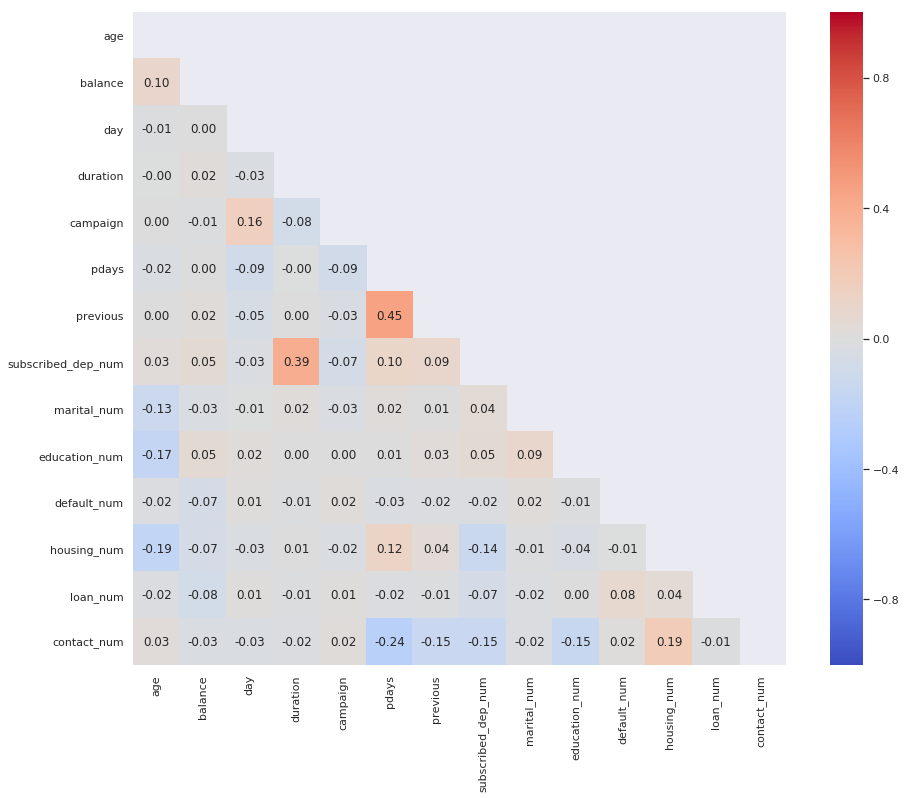

In [0]:
#Eliminamos el triángulo superior de la matriz de correlación y la representamos.

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

corr_matrix = corr_matrix.mask(mask)
corr_matrix

plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')


Listamos las correlaciones de columnas por encima del valor absoluto de 0,30

In [0]:
#Estudio de correlación de una variable respecto al resto de variables numéricas
for cols in corr_matrix_pd.columns: 
  
  df_numerical_corr = corr_matrix_pd[cols]
  
  
  df_numerical_most_corr = df_numerical_corr[abs(df_numerical_corr) > 0.3].sort_values(ascending=False) 
  
  diab_num_corr =  corr_matrix_pd[cols]
  
  diab_num_most_corr = diab_num_corr[(abs(diab_num_corr) > 0.3)]  
  
  if df_numerical_most_corr.size > 1:
      print('* Variable --> ', cols, '\n')
      
      for i, v in df_numerical_most_corr.items():
        
        if i!=cols:
           print('     {:20} {:>10}'.format(i, v))
      
      print('\n--------------------------------------------------------')


* Variable -->  duration 

     subscribed_dep_num   0.3945210158945622

--------------------------------------------------------
* Variable -->  pdays 

     previous             0.4542880207055543

--------------------------------------------------------
* Variable -->  previous 

     pdays                0.4542880207055543

--------------------------------------------------------
* Variable -->  subscribed_dep_num 

     duration             0.3945210158945622

--------------------------------------------------------


Aislamos la variable a estudiar **subscribed_dep_num** con el resto.

In [0]:
bank_df_subscribed_dep_num_corrs = bank_df_final.select([F.corr(F.col('subscribed_dep_num'), F.col(c)).alias(c) for c in num_columns if c != 'subscribed_dep_num'])

#Creamos el DataFrame en Pandas a través de un diccionario (Datos) y un índice (variable a comparar)

bank_df_subscribed_dep_num_corrs_pd = pd.DataFrame(bank_df_subscribed_dep_num_corrs.first().asDict(),index=['subscribed_dep_num'])
                  

bank_df_subscribed_dep_num_corrs_pd


,age,balance,day,duration,campaign,pdays,previous,marital_num,education_num,default_num,housing_num,loan_num,contact_num
subscribed_dep_num,0.025155,0.052838,-0.028348,0.394521,-0.073172,0.103323,0.093236,0.043846,0.051341,-0.022419,-0.139173,-0.068185,-0.148395


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

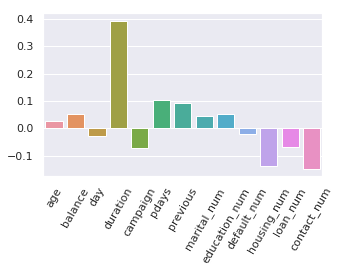

In [0]:
#Representamos graficamente la relación de las variables con subscribed_dep_num

valores = []
for col in bank_df_subscribed_dep_num_corrs_pd.columns:
  valores.append(bank_df_subscribed_dep_num_corrs_pd[col]['subscribed_dep_num'])

columnas = bank_df_subscribed_dep_num_corrs_pd.columns

plt.figure(figsize=(5,3))
sns.barplot(columnas,valores )
plt.xticks(rotation=60)

## Segunda conclusión
Observamos, que tras la conversión a numérico de las variables categóricas sigue existiendo muy poca correlación entre las columnas numéricas y la columna dependiente a predecir **subscribed_dep_num** .

Por tanto las variables que pudieran utilizarse para predecir son:

* **year** : 0,39
* **duration** : 0,33

 
  
   
    
     
      
       
        
         
          
           
            
             
              
               
                
                 








## Revisión variables categóricas vs subscribed_dep_num

In [0]:
marital_subscribed_pd = bank_df_final.groupBy('marital').agg(F.sum('subscribed_dep_num').alias('subscribed_dep_num')).toPandas()
marital_subscribed_pd

,marital,subscribed_dep_num
0,divorced,622
1,married,2755
2,single,1912


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

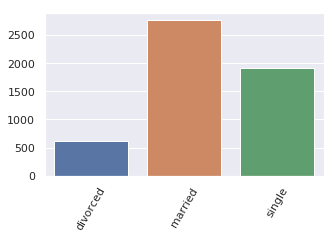

In [0]:
#Representamos graficamente la relación de las variables con subscribed_dep_num

eje_x = []
for i in marital_subscribed_pd['marital']:
    eje_x.append(i)
  
eje_y = []
for i in marital_subscribed_pd['subscribed_dep_num']:
    eje_y.append(i)
    

plt.figure(figsize=(5,3))
sns.barplot(eje_x, eje_y )
plt.xticks(rotation=60)

Puede parecer que los "married" son los que más subscriben, pero como se puede ver en la siguiente gráfica representan un porcentaje muy pequeño sobre su población

In [0]:
marital_subscribed_total_pd = bank_df_final.groupBy('marital','subscribed_dep_boo').count().toPandas()
marital_subscribed_total_pd.head()

,marital,subscribed_dep_boo,count
0,divorced,False,4585
1,single,False,10878
2,married,True,2755
3,divorced,True,622
4,married,False,24459


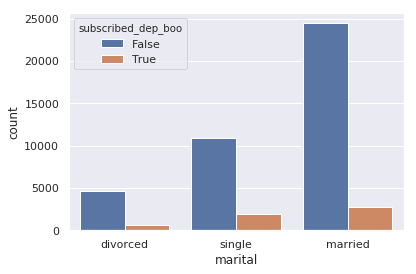

In [0]:

sns.set(style="darkgrid")
ax = sns.barplot( x="marital",y="count", hue='subscribed_dep_boo',data=marital_subscribed_total_pd)

Para continuar habría que seguir haciendo estos estudios con todas las variables categóricas. Pintamos la gráfica de todas ellas.

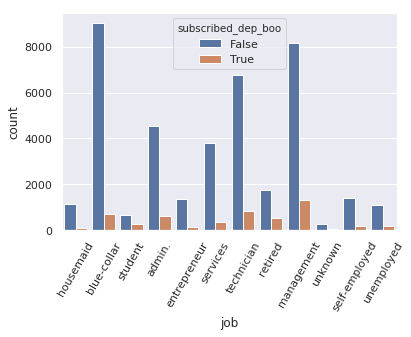

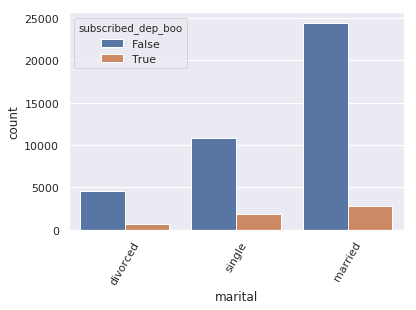

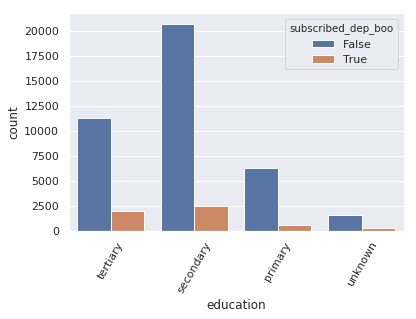

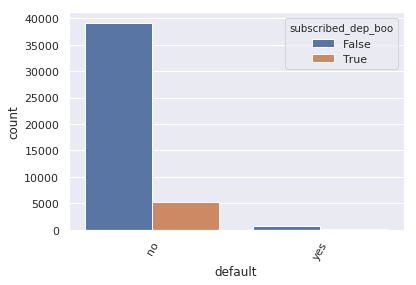

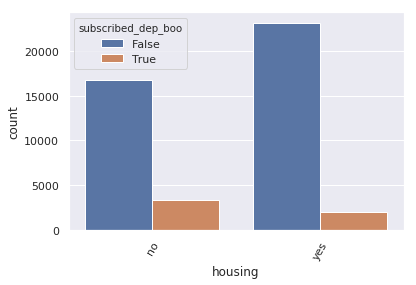

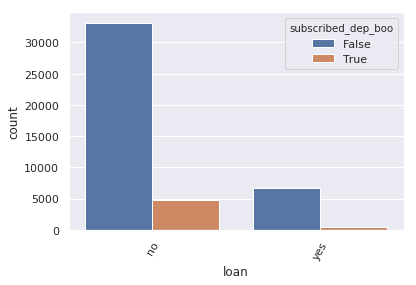

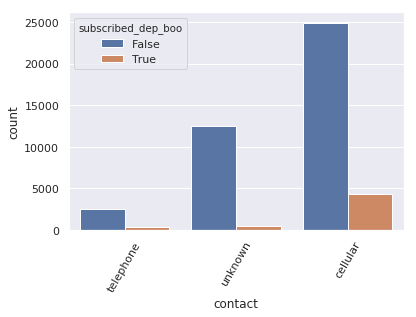

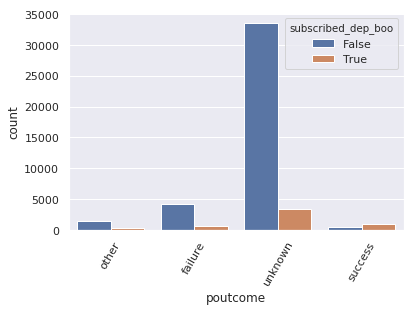

In [0]:
for col in cat_columns:
 
  if col not in  ["y","subscribed_dep_boo","month","year"]:
  
    bank_group = bank_df_final.groupBy(col,'subscribed_dep_boo').count().toPandas()
    sns.set(style="darkgrid")
    ax = sns.barplot( x=col,y="count", hue='subscribed_dep_boo',data=bank_group)
    plt.xticks(rotation=60)
    plt.show()

Vamos a estudiar la estacionalidad de la posible subcripción por fecha. Para ello pintamos los subscritos vs no subscritos por año y mes.

Mostramos a continuación por meses.

In [0]:
bank_df_final.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+------------+------------------+------------------+-----------+-------------+-----------+-----------+--------+-----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|contact_date|subscribed_dep_boo|subscribed_dep_num|marital_num|education_num|default_num|housing_num|loan_num|contact_num|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+------------+------------------+------------------+-----------+-------------+-----------+-----------+--------+-----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|    0|       0| unknown| no|  2008-05-05|             false|                 0|          1|            3|          1|      

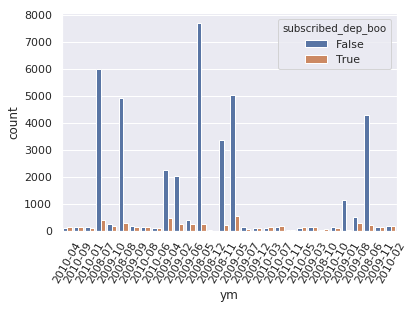

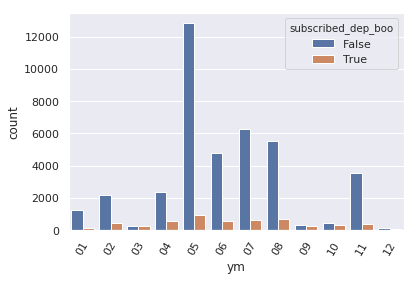

In [0]:
bank_group = bank_df_final.groupBy(F.date_format('contact_date','yyyy-MM').alias('ym'),'subscribed_dep_boo').count().toPandas()
bank_group.head(5)
sns.set(style="darkgrid")
ax = sns.barplot( x='ym',y="count", hue='subscribed_dep_boo',data=bank_group)
plt.xticks(rotation=60)
plt.show()

bank_group = bank_df_final.groupBy(F.date_format('contact_date','MM').alias('ym'),'subscribed_dep_boo').count().toPandas()
bank_group.head(5)
sns.set(style="darkgrid")
ax = sns.barplot( x='ym',y="count", hue='subscribed_dep_boo',data=bank_group)
plt.xticks(rotation=60)
  
plt.show()

# Continuará...

![texto alternativo](https://contenthub-static.grammarly.com/blog/wp-content/uploads/2017/10/thank-you-760x400.jpg)









![texto alternativo](https://e00-elmundo.uecdn.es/assets/multimedia/imagenes/2019/04/24/15561213509470.jpg)